# Sure Tomorrow Insurance Customer Behavior Predictive Modeling

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Prevent line wrapping
pd.set_option('display.max_colwidth', None) # Show full contents of cells
pd.set_option('display.max_rows', None) # Shows all rows


import seaborn as sns

import sklearn.linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import sklearn.preprocessing
from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import train_test_split

from IPython.display import HTML, display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('../data/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4180,1,37.0,35800.0,1,0
4604,1,22.0,34100.0,2,0
4106,0,43.0,50900.0,1,1
4707,0,26.0,36700.0,2,0
3986,1,21.0,38500.0,0,0
702,1,21.0,21300.0,1,0
2173,1,29.0,32000.0,4,0
4996,0,34.0,52400.0,1,0
2725,0,30.0,37200.0,0,0
3073,1,51.0,33400.0,2,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int64')

In [7]:

# check to see that the conversion was successful
df.info()
print()
print('There are', df.duplicated().sum(), 'duplicated rows.')
print('The duplicated rows represent', (df.duplicated().sum()/len(df))*100, '% of the dataset.')
print()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB

There are 153 duplicated rows.
The duplicated rows represent 3.06 % of the dataset.



,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

__CONCLUSIONS & COMMENTARY:__
- There is no missing data and all column names have been reformatted to `snake_case`.
- For clarity and ease of subsequent calculation, the `age` column datatype was changed from `float64` to `int64` successfully.
- The data was reviewed for duplicates, of which 153 rows were duplicated.
    - This only represented 3.06% of the total dataset.
    - No duplicates shall be dropped as this is an accurate representation of reality, where it is almost certain that there is more than one person that is the same age, gender, income level, family size, and has pulled the same number of insurance benefits.
- There does not appear to be any obvious issues with the descriptive statistics at this point.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

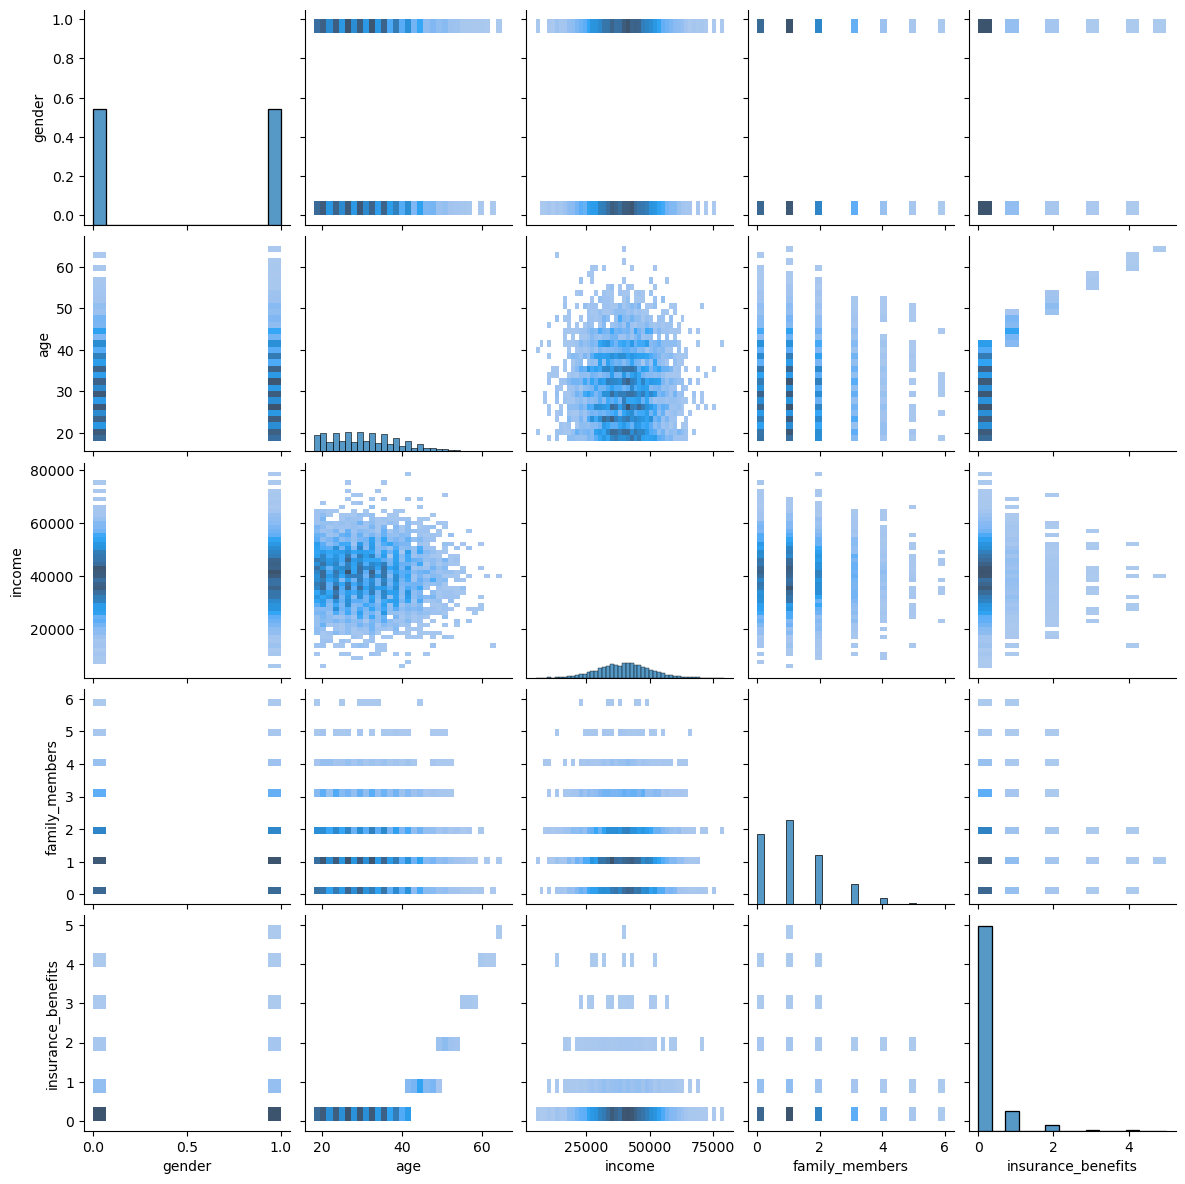

In [9]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [10]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [11]:

def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs =  NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res


Scaling the data.

In [12]:

feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


C:\Users\sethc\AppData\Local\Temp\ipykernel_21776\3567492719.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
C:\Users\sethc\AppData\Local\Temp\ipykernel_21776\3567492719.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [13]:
print(df_scaled.sample(5))
print()
print(df_scaled[feature_names].describe())

      gender       age    income  family_members  insurance_benefits
3247       1  0.400000  0.463291        0.333333                   0
3250       1  0.461538  0.370886        0.333333                   0
1870       1  0.415385  0.370886        0.000000                   0
1905       1  0.400000  0.481013        0.333333                   0
1378       0  0.553846  0.334177        0.000000                   0

            gender          age       income  family_members
count  5000.000000  5000.000000  5000.000000     5000.000000
mean      0.499000     0.476197     0.505270        0.199033
std       0.500049     0.129859     0.125318        0.181898
min       0.000000     0.276923     0.067089        0.000000
25%       0.000000     0.369231     0.421519        0.000000
50%       0.000000     0.461538     0.508861        0.166667
75%       1.000000     0.569231     0.589873        0.333333
max       1.000000     1.000000     1.000000        1.000000


Now, let's get similar records for a given one for every combination

In [14]:
# Set the objects and neighbors for each scenario for comparability
n = 0 # first object (position) in dataset
k = 20 # look for k nearest neighbors

# Scenario 1: Original Data & Euclidean
print("Scenario 1: Original Data & Euclidean")
display(get_knn(df, n, k, 'euclidean'))

print()

# Scenario 2: Original Data & Manhattan
print("Scenario 2: Original Data & Manahattan")
display(get_knn(df, n, k, "cityblock"))

print()

# Scenario 3: Scaled Data & Euclidean
print("Scenario 3: Scaled Data & Euclidean")
display(get_knn(df_scaled, n, k, "euclidean"))

print()

# Scenario 4: Scaled Data & Manhattan
print("Scenario 4: Scaled Data & Manhattan")
display(get_knn(df_scaled, n, k, "cityblock"))

Scenario 1: Original Data & Euclidean


c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625
815,1,37,49600.0,2,0,4.123106
4661,0,45,49600.0,0,1,4.242641
2125,0,37,49600.0,2,0,4.242641
2349,1,46,49600.0,2,1,5.099020
3900,1,36,49600.0,0,0,5.099020



Scenario 2: Original Data & Manahattan


c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
815,1,37,49600.0,2,0,5.0
3424,0,38,49600.0,0,0,5.0
4661,0,45,49600.0,0,1,6.0
3900,1,36,49600.0,0,0,6.0
2125,0,37,49600.0,2,0,6.0
2349,1,46,49600.0,2,1,6.0



Scenario 3: Scaled Data & Euclidean


c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.017754
4869,1,0.646154,0.637975,0.166667,1,0.018418
3275,1,0.646154,0.651899,0.166667,1,0.028550
1567,1,0.615385,0.602532,0.166667,0,0.029624
2103,1,0.630769,0.596203,0.166667,0,0.031646
3365,1,0.630769,0.596203,0.166667,0,0.031646
124,1,0.661538,0.635443,0.166667,1,0.031693
3636,1,0.615385,0.600000,0.166667,0,0.031815



Scenario 4: Scaled Data & Manhattan


c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.024245
4869,1,0.646154,0.637975,0.166667,1,0.025511
2103,1,0.630769,0.596203,0.166667,0,0.031646
3365,1,0.630769,0.596203,0.166667,0,0.031646
124,1,0.661538,0.635443,0.166667,1,0.038364
4305,1,0.630769,0.588608,0.166667,0,0.039241
3275,1,0.646154,0.651899,0.166667,1,0.039435
1567,1,0.615385,0.602532,0.166667,0,0.040701


c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\sethc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


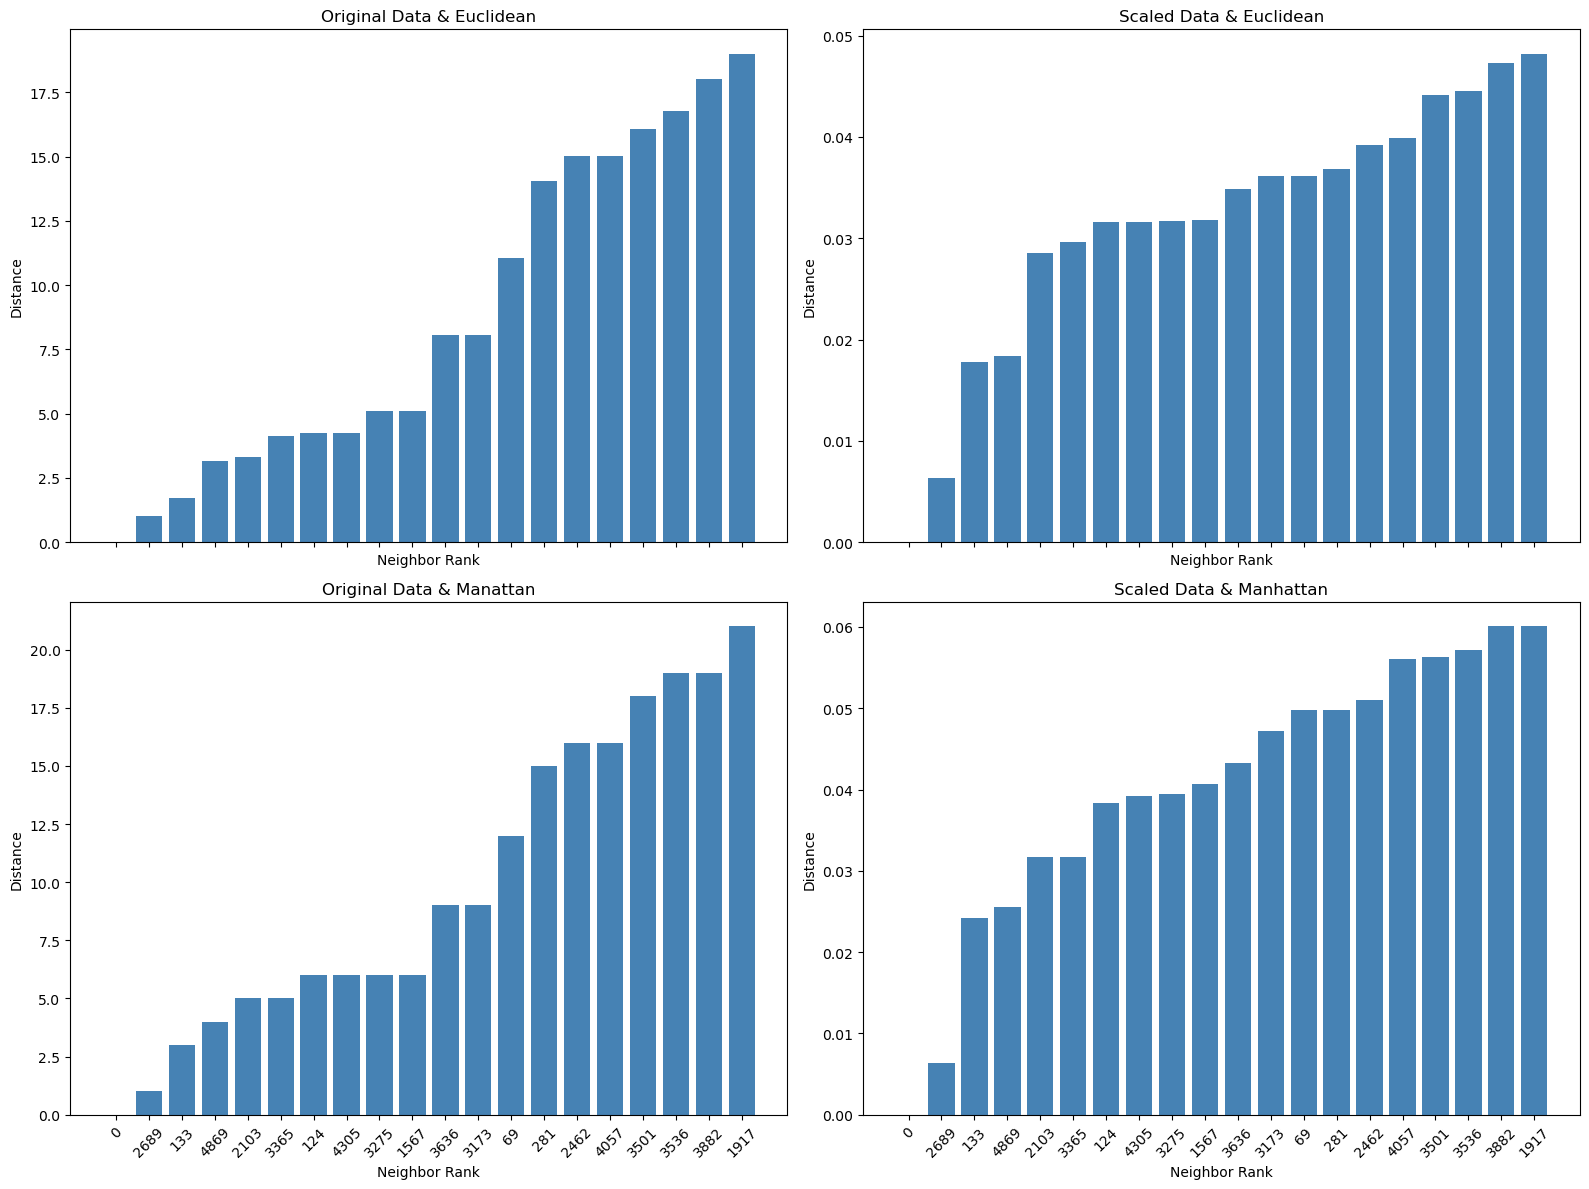

In [15]:
# Visualize

orig_euc = get_knn(df, n, k, 'euclidean')
orig_man = get_knn(df, n, k, 'manhattan')
scaled_euc = get_knn(df_scaled, n, k, 'euclidean')
scaled_man = get_knn(df_scaled, n, k, 'manhattan')

fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

def plot_bar(ax, df, title):
    ax.bar(range(len(df)), df['distance'], color='steelblue')
    ax.set_title(title)
    ax.set_xlabel('Neighbor Rank')
    ax.set_ylabel('Distance')
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df.index, rotation=45)

# Top - Euclidean
plot_bar(axs[0,0], orig_euc, 'Original Data & Euclidean')
plot_bar(axs[0,1], scaled_euc, 'Scaled Data & Euclidean')

# Bottom - Manhattan
plot_bar(axs[1,0], orig_man,'Original Data & Manattan')
plot_bar(axs[1,1], scaled_man, 'Scaled Data & Manhattan')

plt.tight_layout()
plt.show()

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

- When the data is not scaled, large swings in numerical features relative to other features (such as income vs. gender) result in disproprortionate influence.
- The income feature becomes significantly more important than these other features when (in this case), all of the features are deemed equal in importance.
- Scaling equalizes the dataset to ensure that the numerical impact is normalized across all of the features and a more accurate depiction of the distance can be visualized.
- This is shown in the visualization above, where both distance metrics significantly compressed the distance axis post-scaling.


**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

- Relative to their Euclidean counterparts, the Manhattan distance results visualized above appear to show more neighbors in tight clusters the same distance from the reference datapoint.
- The Manhattan behavior appears slightly flatter than the Euclidean data in part because of  the absolute difference values being taken rather than the squares taken by the Euclidean distance metric.
- Manhattan distances are compressed whereas the Euclidean distances are magnified due to the squaring.


# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [16]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [17]:
# check for the class imbalance with value_counts()
print(df['insurance_benefits_received'].value_counts())
print()
print(f"Class Proportions:\n{df['insurance_benefits_received'].value_counts(normalize=True)}")

insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64

Class Proportions:
insurance_benefits_received
0    0.8872
1    0.1128
Name: proportion, dtype: float64


In [18]:
# Set up training and test splits
feats = df[feature_names]
targ = df['insurance_benefits_received']

feats_train, feats_test, targ_train, targ_test = train_test_split(
    feats, targ, test_size=0.3, random_state=42, stratify=targ
)

# Prep scaled data for training
scaler = MaxAbsScaler().fit(feats_train)
scaled_feats_train = scaler.transform(feats_train)
scaled_feats_test = scaler. transform(feats_test)


In [19]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

    return f1_score

In [20]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [21]:

dummy_f1s = {}
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    f1 = eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    dummy_f1s[f"P={P:.2f}"] = f1
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [22]:
# KNeighborsClassifier Model Evaluation - Original Data
f1_unscaled = []
for n in range(1, 11):
    print(f"\nEvaluating KNeighborsClassifier model with n_neighbors={n}")
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(feats_train, targ_train)
    y_pred = model.predict(feats_test)

    f1 = eval_classifier(targ_test, y_pred)
    f1_unscaled.append(f1)



Evaluating KNeighborsClassifier model with n_neighbors=1
F1: 0.60
Confusion Matrix
[[0.87133333 0.016     ]
 [0.058      0.05466667]]

Evaluating KNeighborsClassifier model with n_neighbors=2
F1: 0.33
Confusion Matrix
[[0.88       0.00733333]
 [0.08866667 0.024     ]]

Evaluating KNeighborsClassifier model with n_neighbors=3
F1: 0.34
Confusion Matrix
[[0.87466667 0.01266667]
 [0.08666667 0.026     ]]

Evaluating KNeighborsClassifier model with n_neighbors=4
F1: 0.22
Confusion Matrix
[[0.886      0.00133333]
 [0.09866667 0.014     ]]

Evaluating KNeighborsClassifier model with n_neighbors=5
F1: 0.26
Confusion Matrix
[[0.88266667 0.00466667]
 [0.09533333 0.01733333]]

Evaluating KNeighborsClassifier model with n_neighbors=6
F1: 0.09
Confusion Matrix
[[0.88733333 0.        ]
 [0.10733333 0.00533333]]

Evaluating KNeighborsClassifier model with n_neighbors=7
F1: 0.09
Confusion Matrix
[[0.886      0.00133333]
 [0.10733333 0.00533333]]

Evaluating KNeighborsClassifier model with n_neighbors

In [23]:
# KNeighborsClassifier Model Evaluation - Scaled Data
f1_scaled = []
for n in range(1, 11):
    print(f"\nEvaluating KNeighborsClassifier model with n_neighbors={n}")
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(scaled_feats_train, targ_train)
    y_pred = model.predict(scaled_feats_test)

    f1 = eval_classifier(targ_test, y_pred)
    f1_scaled.append(f1)



Evaluating KNeighborsClassifier model with n_neighbors=1
F1: 0.91
Confusion Matrix
[[0.87866667 0.00866667]
 [0.01133333 0.10133333]]

Evaluating KNeighborsClassifier model with n_neighbors=2
F1: 0.91
Confusion Matrix
[[0.88533333 0.002     ]
 [0.016      0.09666667]]

Evaluating KNeighborsClassifier model with n_neighbors=3
F1: 0.94
Confusion Matrix
[[0.88466667 0.00266667]
 [0.01133333 0.10133333]]

Evaluating KNeighborsClassifier model with n_neighbors=4
F1: 0.89
Confusion Matrix
[[0.886      0.00133333]
 [0.02133333 0.09133333]]

Evaluating KNeighborsClassifier model with n_neighbors=5
F1: 0.92
Confusion Matrix
[[0.88466667 0.00266667]
 [0.01533333 0.09733333]]

Evaluating KNeighborsClassifier model with n_neighbors=6
F1: 0.89
Confusion Matrix
[[0.88733333 0.        ]
 [0.022      0.09066667]]

Evaluating KNeighborsClassifier model with n_neighbors=7
F1: 0.92
Confusion Matrix
[[8.86666667e-01 6.66666667e-04]
 [1.60000000e-02 9.66666667e-02]]

Evaluating KNeighborsClassifier model 

In [24]:
df_results = pd.DataFrame({
    'kNN_unscaled_F1': f1_unscaled,
    'kNN_scaled_F1': f1_scaled,
}, index=range(1,11))

dummy_df = pd.DataFrame.from_dict(dummy_f1s, orient='index', columns=['Dummy_F1'])

display(df_results)
display(dummy_df)

,kNN_unscaled_F1,kNN_scaled_F1
1,0.596364,0.910180
2,0.333333,0.914826
3,0.343612,0.935385
4,0.218750,0.889610
5,0.257426,0.915361
6,0.090395,0.891803
7,0.089385,0.920635
8,0.034884,0.892508
9,0.045977,0.924051
10,0.023392,0.891803


,Dummy_F1
P=0.00,0.000000
P=0.11,0.120721
P=0.50,0.198079
P=1.00,0.202732


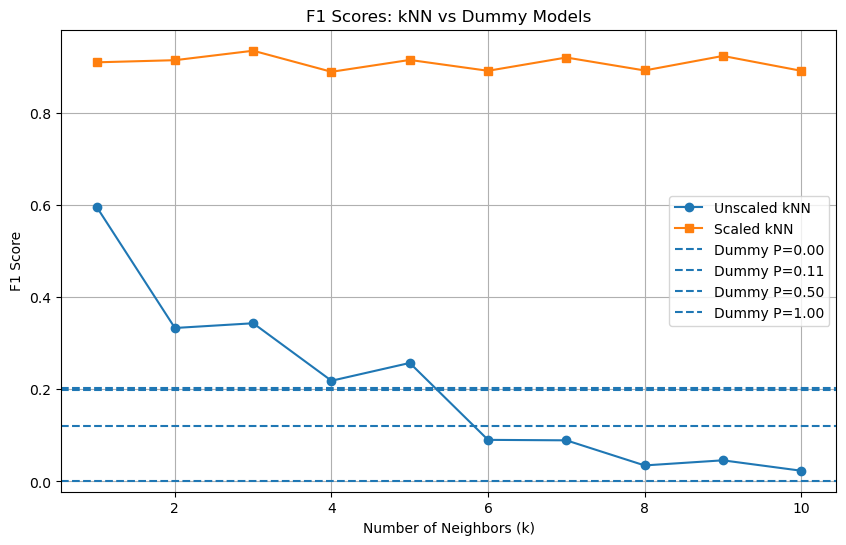

In [25]:
# Visualization
plt.figure(figsize=(10,6))
ks = range(1, 11)

# kNN lines
plt.plot(ks, f1_unscaled, marker='o', label='Unscaled kNN')
plt.plot(ks, f1_scaled, marker='s', label='Scaled kNN')

# dummy baselines
for label, f1 in dummy_f1s.items():
    plt.axhline(f1, linestyle='--', label=f'Dummy {label}')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('F1 Scores: kNN vs Dummy Models')
plt.legend()
plt.grid(True)
plt.show()

__CONCLUSIONS & COMMENTARY:__
- The data was split in a 70/30 ratio training vs. testing, and was stratified to assist with the class imbalance issue, as there were significantly more customers who did not use their insurance benefits than there were those who used it even one time.
    - The majority class (those customers who had not taken a single insurance benefit) represented more than 88% of the data.
- The **Dummy Classifier** Model simply a baseline classifier that makes random predictions using fixed probabilities, which are then compared to the true target labels.
    - The `f1 scores` presented by the **Dummy Classifier** Model did not exceed 0.20, which is to be expected and is indiciative of poor recall and precision.
- The **Unscaled KNeighbors Classifier** Model did perform better than the **Dummy Classifier** until the iterations following the addition of a 5th neighbor, where performance then fell off a cliff.
- The **Scaled Kneighbors Classifier** Model performed the best, with exceptional `f1 scores` throughout the iterative range, the strongest of which was 0.94 at k=3.
    - This makes sense, as the scaled data ensures that all of the features are weighted with the same level of importance, and the relationships amongst the features are accurately represented.
    - The Confusion Matrix for k=3 also supported the premise that this is the strongest model, with the model accurately selected the correct negatives 88% of the time and correct positives 10% of the time.
- The visualization above makes clear the difference in model suitability for the three candidates.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$


Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [26]:
class MyLinearRegression:
    
    def __init__(self):

        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = ((np.linalg.inv(X2.T @ X2)).dot(X2.T)).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights) 
        return y_pred

In [27]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [28]:
# Original Data
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)
print()
print(f"✅ Linear Regression Model - Original Data:")
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)


[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]

✅ Linear Regression Model - Original Data:
RMSE: 0.34
R2: 0.66


In [29]:
# Scaled Data
scaler = MaxAbsScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_scaled = MyLinearRegression()

lr_scaled.fit(X_train_scaled, y_train)
print(lr_scaled.weights)
print()
print(f"✅ Linear Regression Model - Scaled Data:")
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]

✅ Linear Regression Model - Scaled Data:
RMSE: 0.34
R2: 0.66


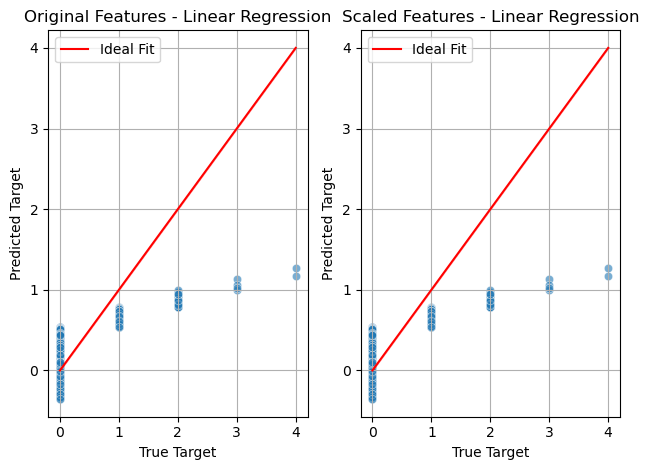

In [30]:
# Original model predictions
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal Fit')
plt.xlabel('True Target')
plt.ylabel('Predicted Target')
plt.title('Original Features - Linear Regression')
plt.legend()
plt.grid(True)

# Scaled model predictions
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred_scaled, alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', label='Ideal Fit')
plt.xlabel('True Target')
plt.ylabel('Predicted Target')
plt.title('Scaled Features - Linear Regression')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

__CONCLUSIONS & COMMENTARY__:
- For both the Unscaled and Scaled Linear Regression models, the RMSE reported was 0.34.
    - In the context of discrete insurance benefit utilization where the maximum value has been 4 benefits utilized, this is particularly large for an RMSE.
- The fact that the RMSE did not improve after scaling is indicative of the fact that the scaling does not have an impact on the magnitude of the linear relationship within the data.
    - The weights changed slightly, however, as the model begins to learn how to create a line of best fit with new magnitudes in the scaled dataset.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [31]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [32]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [33]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [34]:
check_p = np.linalg.det(P)
if np.isclose(check_p, 0):
    print(f"⛔ P is not invertible.")
else:
    print(f"✅ P is invertible.")

✅ P is invertible.


Can you guess the customers' ages or income after the transformation?

In [35]:
X_obscure = X @ P
display(X_obscure)
print()
print(f"The customer ages and income are unable to be determined after the transformation.")

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]],
      shape=(5000, 4))


The customer ages and income are unable to be determined after the transformation.


Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [36]:
P_inv = np.linalg.inv(P)
X_recovered = X_obscure @ P_inv
print(np.allclose(X, X_recovered))
print()
display(X_recovered)

True



array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-3.63797881e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [ 1.81898940e-12,  2.90000000e+01,  2.10000000e+04,
         0.00000000e+00],
       ...,
       [ 0.00000000e+00,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]], shape=(5000, 4))

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [37]:
# Establish preview rows
preview = 5

# Make dfs for viewability
df_og = pd.DataFrame(X[:preview], columns=feature_names)
df_obscure = pd.DataFrame(X_obscure[:preview], columns=[f"P{i+1}" for i in range(X.shape[1])])
df_recover = pd.DataFrame(X_recovered[:preview], columns=feature_names)

print("Original Data:")
display(df_og)

print("Obscured Data:")
display(df_obscure)

print("Recovered Data:")
display(df_recover)

Original Data:


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


Obscured Data:


,P1,P2,P3,P4
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


Recovered Data:


,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-3.637979e-12,46.0,38000.0,1.000000e+00
2,1.818989e-12,29.0,21000.0,0.000000e+00
3,0.000000e+00,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,3.637979e-12


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

- Though my preview selection does not show any differences between the recovered data and the original, there would no doubt be some very slight differences between them if several additional rows were audited.
- The primary reason for this is because there are floating-point rounding errors at play during the matrix inversion operations.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$
1. How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 
2. What would be predicted values with $w_P$? 
3. What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook.
There are useful formulas in there!
No code is necessary in this section, only analytical explanation!

**Answer**

1. $w_P = (P)^{-1}w$
2. $\hat{y} = X w$
3. The RMSE does not change as the predicted values do not change with an obfuscated dataset.

**Analytical proof**

Question 1:
$$
w = (X^T X)^{-1} X^T y
$$
$$
X_P = X P
$$
$$
w_P = \left[(X P)^T (X P)\right]^{-1} (X P)^T y
$$
$$
\begin{align*}
(XP)^T (XP) &= P^T X^T X P \\
w_P &= \left(P^T X^T X P\right)^{-1} P^T X^T y
\end{align*}
$$
$$
\left(P^T X^T X P\right)^{-1} = P^{-1} (X^T X)^{-1} (P^T)^{-1}
$$
$$
w_P = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$
$$
\boxed{w_P = P^{-1} w}
$$

Question 2:
$$
\hat{y} = X_P w_P = X P w_P = X P (P^{-1} w) = X (P P^{-1}) w = X w
$$

## Test Linear Regression With Data Obfuscation


Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?


**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Build a class that can run a Linear Regression model with obfuscation as an optional parameter.
- Train the Linear Regression model on the original data without obfuscating the features and log the RMSE and R2 values.
- Train the Linear Regression model using $XP$ as the new feature matrix and log the RMSE and R2 values.
- Compare the report-out values.

In [38]:
# Generate square matrix of random numbers
rng = np.random.default_rng(seed=12345)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [39]:
# Check that P is invertible
check_p = np.linalg.det(P)
if np.isclose(check_p, 0):
    print(f"⛔ P is not invertible.")
else:
    print(f"✅ P is invertible.")

✅ P is invertible.


In [40]:
# Create customer class for in-situ obfuscation during LR
class LinearRegressionObfuscator:
    def __init__(self, P=None):
        """
        If P=P == obfuscation flag.
        """
        self.P = P
        self.model = MyLinearRegression()
    
    def fit(self, X_train, y_train):
        if self.P is not None:
            X_train = X_train @ self.P
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        if self.P is not None:
            X_test = X_test @ self.P
        return self.model.predict(X_test)
    
    def evaluate(self, y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        return rmse, r2

# Original Data
orig_model = LinearRegressionObfuscator(P=None)
orig_model.fit(X_train, y_train)
y_pred_orig = orig_model.predict(X_test)
rmse_orig, r2_orig = orig_model.evaluate(y_test, y_pred_orig)

print("✅ Original Data Performance:")
print(f"RMSE: {rmse_orig:.2f}")
print(f"R²: {r2_orig:.2f}")

# Obfuscated Model
obf_model = LinearRegressionObfuscator(P=P)
obf_model.fit(X_train, y_train)
y_pred_obf = obf_model.predict(X_test)
rmse_obf, r2_obf = obf_model.evaluate(y_test, y_pred_obf)

print("\n✅ Obfuscated Data Performance:")
print(f"RMSE: {rmse_obf:.2f}")
print(f"R²: {r2_obf:.2f}")

# Log Results
if np.allclose(y_pred_orig, y_pred_obf):
    print("\n🎉 Predicted values are identical!")
else:
    print("\n⚠️ Predicted values differ!")



✅ Original Data Performance:
RMSE: 0.34
R²: 0.43

✅ Obfuscated Data Performance:
RMSE: 0.34
R²: 0.43

⚠️ Predicted values differ!


__CONCLUSIONS & COMMENTARY:__
- The Linear Regression models did not differ in terms of RMSE or R2, regardless of obfuscation status.
    - This computationally proves out what was explained in **TASK 3** above, where the underlying linear relationship within the data will not be impacted by obfuscation.
- Conversely, the predicted values differ, due to the matrix operations performed to obscure the feature specifics.

# Conclusions

__EDA__:
- There is no missing data and all column names have been reformatted to `snake_case`.
- For clarity and ease of subsequent calculation, the `age` column datatype was changed from `float64` to `int64` successfully.
- The data was reviewed for duplicates, of which 153 rows were duplicated.
    - This only represented 3.06% of the total dataset.
    - No duplicates shall be dropped as this is an accurate representation of reality, where it is almost certain that there is more than one person that is the same age, gender, income level, family size, and has pulled the same number of insurance benefits.
- There does not appear to be any obvious issues with the descriptive statistics at this point.

__TASK 1:__

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

- When the data is not scaled, large swings in numerical features relative to other features (such as income vs. gender) result in disproprortionate influence.
- The income feature becomes significantly more important than these other features when (in this case), all of the features are deemed equal in importance.
- Scaling equalizes the dataset to ensure that the numerical impact is normalized across all of the features and a more accurate depiction of the distance can be visualized.
- This is shown in the visualization above, where both distance metrics significantly compressed the distance axis post-scaling.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

- Relative to their Euclidean counterparts, the Manhattan distance results visualized above appear to show more neighbors in tight clusters the same distance from the reference datapoint.
- The Manhattan behavior appears slightly flatter than the Euclidean data in part because of  the absolute difference values being taken rather than the squares taken by the Euclidean distance metric.
- Manhattan distances are compressed whereas the Euclidean distances are magnified due to the squaring.

__TASK 2:__
- The data was split in a 70/30 ratio training vs. testing, and was stratified to assist with the class imbalance issue, as there were significantly more customers who did not use their insurance benefits than there were those who used it even one time.
    - The majority class (those customers who had not taken a single insurance benefit) represented more than 88% of the data.
- The **Dummy Classifier** Model simply a baseline classifier that makes random predictions using fixed probabilities, which are then compared to the true target labels.
    - The `f1 scores` presented by the **Dummy Classifier** Model did not exceed 0.20, which is to be expected and is indiciative of poor recall and precision.
- The **Unscaled KNeighbors Classifier** Model did perform better than the **Dummy Classifier** until the iterations following the addition of a 5th neighbor, where performance then fell off a cliff.
- The **Scaled Kneighbors Classifier** Model performed the best, with exceptional `f1 scores` throughout the iterative range, the strongest of which was 0.94 at k=3.
    - This makes sense, as the scaled data ensures that all of the features are weighted with the same level of importance, and the relationships amongst the features are accurately represented.
    - The Confusion Matrix for k=3 also supported the premise that this is the strongest model, with the model accurately selected the correct negatives 88% of the time and correct positives 10% of the time.
- The visualization above makes clear the difference in model suitability for the three candidates.

__TASK 3:__
- For both the Unscaled and Scaled Linear Regression models, the RMSE reported was 0.34.
    - In the context of discrete insurance benefit utilization where the maximum value has been 4 benefits utilized, this is particularly large for an RMSE.
- The fact that the RMSE did not improve after scaling is indicative of the fact that the scaling does not have an impact on the magnitude of the linear relationship within the data.
    - The weights changed slightly, however, as the model begins to learn how to create a line of best fit with new magnitudes in the scaled dataset.

__TASK 4__:
- The Linear Regression models did not differ in terms of RMSE or R2, regardless of obfuscation status.
    - This computationally proves out what was explained in **TASK 3** above, where the underlying linear relationship within the data will not be impacted by obfuscation.
- Conversely, the predicted values differ, due to the matrix operations performed to obscure the feature specifics.